In [25]:
import sys, os
import random
import numpy as np
from glob import glob
import pandas as pd
import kaldiio
import torch
import pickle


random.seed(1)

print(torch.version)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

in_set = ['ENG', 'GER', 'ICE', 'FRE', 'SPA', 'ARA', 'RUS', 'BEN', 'KAS', 'GRE', 'CAT', 'KOR', 'TUR', 'TAM', 'TEL', 'CHI', 'TIB', 'JAV', 'EWE', 'HAU', 'LIN', 'YOR', 'HUN', 'HAW', 'MAO', 'ITA', 'URD', 'SWE', 'PUS', 'GEO', 'HIN', 'THA']
out_of_set = ['DUT', 'HEB', 'UKR', 'BUL', 'PER', 'ALB', 'UIG', 'MAL', 'BUR', 'IBA', 'ASA', 'AKU', 'ARM', 'HRV', 'FIN', 'JPN', 'NOR', 'NEP', 'RUM']

langs = in_set + out_of_set

num_in_set = 32

in_set = langs[:num_in_set]
out_of_set = langs[num_in_set:]

root_dir = "/home/sp4013/kaldi-trunk/egs/lid/s1/db/cu-multilang-dataset/"


assert(len(in_set) + len(out_of_set) == 51)
assert(len(set(in_set).intersection(set(out_of_set))) == 0)
for lang in os.listdir(root_dir):
    assert(lang in in_set or lang in out_of_set)

print("\n-----Getting Train/Test Data-----\n")

data = []
eng_data = []
max_sample_length = 300
num_chunks_per_file = 160
num_files = 30

for i,lang in enumerate(in_set, 0):
    print(lang, "(In-set)" if lang in in_set else "(Out-of-set)")
    
    chunks = []
    for f_idx in range(1, num_files + 1):
        if lang == "ENG" and f_idx >= 27:
            continue
        
        filepath = root_dir + lang + '/data/raw_mfcc_pitch_' + lang + '.' + str(f_idx) + '.ark'
        file_chunks = []
        
        for key, numpy_array in kaldiio.load_ark(filepath):
            curr_len = len(numpy_array)
            
#             chunks +=  np.split(numpy_array, np.arange(max_sample_length, curr_len, max_sample_length))
            if curr_len >= max_sample_length:
                file_chunks +=  np.split(numpy_array, np.arange(max_sample_length, curr_len, max_sample_length))[:-1]
            else:
                padded_chunk = np.pad(numpy_array, ((max_sample_length - curr_len, 0), (0, 0)), "constant")
                file_chunks += [padded_chunk]
                
#             chunks += file_chunks
            if len(file_chunks) >= num_chunks_per_file:
                chunks += file_chunks
                break
    
    random.shuffle(chunks)
    chunks= np.array(chunks)
    
    for chunk in chunks:
        inputs = torch.from_numpy(chunk)
        inputs.to(device)
        labels = torch.from_numpy(np.array([i if lang in in_set else -1]))
        labels.to(device)
        
        data.append((inputs, labels))

print()

print(len(data))

print("\n-----Finished Data Splitting-----\n")

<module 'torch.version' from '/home/sp4013/anaconda3/lib/python3.9/site-packages/torch/version.py'>
cuda:0

-----Getting Train/Test Data-----

ENG (In-set)
GER (In-set)
ICE (In-set)
FRE (In-set)
SPA (In-set)
ARA (In-set)
RUS (In-set)
BEN (In-set)
KAS (In-set)
GRE (In-set)
CAT (In-set)
KOR (In-set)
TUR (In-set)
TAM (In-set)
TEL (In-set)
CHI (In-set)
TIB (In-set)
JAV (In-set)
EWE (In-set)
HAU (In-set)
LIN (In-set)
YOR (In-set)
HUN (In-set)
HAW (In-set)
MAO (In-set)
ITA (In-set)
URD (In-set)
SWE (In-set)
PUS (In-set)
GEO (In-set)
HIN (In-set)
THA (In-set)

140365

-----Finished Data Splitting-----



In [26]:
from torch.utils.data import Dataset

class LanguageDataset(Dataset):
    def __init__(self, chunks):
        self.chunks=chunks
        
    def __len__(self):
        return len(self.chunks)
    
    def __getitem__(self, index):
        el = self.chunks[index]
        sample = el[0]
        label = el[1][0]
        
        return sample, label

In [27]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from tdnn import TDNN
from pytorch_model_summary import summary


class Net(nn.Module):
    def __init__(self, in_size, num_classes):
        super().__init__()
        
        self.layer1 = TDNN(input_dim=in_size, output_dim=256, context_size=3)
        self.layer2 = TDNN(input_dim=256, output_dim=256, context_size=3, dilation=1)
        self.layer3 = TDNN(input_dim=256, output_dim=256, context_size=3, dilation=1)
        self.layer4 = TDNN(input_dim=256, output_dim=256, context_size=1)
        self.layer5 = TDNN(input_dim=256, output_dim=256, context_size=1)
        self.final_layer = TDNN(input_dim=256, output_dim=num_classes, context_size=1)
        
    def forward(self, x):
        forward_pass = nn.Sequential(
            self.layer1,
            nn.ReLU(),
            self.layer2,
            nn.ReLU(),
            self.layer3,
            nn.ReLU(),
            self.layer4,
            nn.ReLU(),
            self.layer5,
            nn.ReLU(),
            self.final_layer)
        
        return forward_pass(x)
    
print(summary(Net(16, len(in_set)), torch.zeros((256, 300, 16)), show_input=False))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
            TDNN-1     [256, 298, 256]          13,056          13,056
            TDNN-2     [256, 296, 256]         197,376         197,376
            TDNN-3     [256, 294, 256]         197,376         197,376
            TDNN-4     [256, 294, 256]          66,304          66,304
            TDNN-5     [256, 294, 256]          66,304          66,304
            TDNN-6      [256, 294, 32]           8,288           8,288
Total params: 548,704
Trainable params: 548,704
Non-trainable params: 0
-----------------------------------------------------------------------


In [28]:
# def create_batches(data, batch_size=128):
#     len_data = len(data)
#     num_batches = (len_data // batch_size) + 1
    
#     batch = []

#     for i, d in enumerate(data):
#         batch.append(d)
#         if (i + 1) % batch_size == 0:
#             yield batch
#             batch = []

#         yield batch



In [29]:
# Get data loader
from torch.utils.data.dataloader import DataLoader


batch_size = 512

dataset = LanguageDataset(data)
len_train_set = int(0.8 * len(dataset))
train_set, val_set = torch.utils.data.random_split(dataset, [len_train_set, len(dataset) - len_train_set])
train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(dataset=val_set, shuffle=True, batch_size=batch_size)

In [30]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train_model(model, train_loader, optimizer, criterion, device=None):
    train_loss = 0.0
    train_acc = 0.0

    model.train()

    for x, y in train_loader:
      # Send to GPU if available
      if device is not None:
        x = x.to(device)
        y = y.to(device)

      optimizer.zero_grad()

      y_pred = model(x)
      y_pred = torch.mean(y_pred, 1)
      loss = criterion(y_pred, y)
      acc = calculate_accuracy(y_pred, y)

      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_acc += acc.item()

    return train_loss / len(train_loader), train_acc / len(train_loader)


def evaluate_model(model, val_loader, criterion, device=None):
    val_loss = 0.0
    val_acc = 0.0

    model.eval()

    with torch.no_grad():
        for x, y in val_loader:
          # Send to GPU if available
          if device is not None:
            x = x.to(device)
            y = y.to(device)

          y_pred = model(x)
          y_pred = torch.mean(y_pred, 1)
          loss = criterion(y_pred, y)
          acc = calculate_accuracy(y_pred, y)

          val_loss += loss.item()
          val_acc += acc.item()

    return val_loss / len(val_loader), val_acc / len(val_loader)


In [32]:
from pickle import Pickler, Unpickler


# Initialize the TDNN, loss, and optimizer
# print(len(in_set))
net = Net(16, len(in_set))
net.to(device)
criterion = nn.CrossEntropyLoss() # a common loss function for multi-class classification problems
optimizer = optim.AdamW(net.parameters(), lr=0.001) # a common optimizer for multi-class classification problems


# Train the TDNN network
do_training = True # whether to train or to load a saved model
SAVE_PATH = 'saved_models/tdnn-256-3s'
LOAD_PATH = 'saved_models/tdnn-256-3s'

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_loss = float('inf')
best_epoch = 0

if do_training:
    print('Started Training')

    for epoch in range(12):  # number of epochs
        train_loss, train_accuracy = train_model(net, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy = evaluate_model(net, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_loss < best_loss:
          best_loss = val_loss
          best_epoch = epoch
            
          with open(SAVE_PATH + ".pickle", "wb") as outfile:
            pickle.dump(net, outfile, protocol=4)


        print("Epoch: " + str(epoch) + ", Train Loss: " + str(train_loss) + ", Train Accuracy: " + str(train_accuracy) + \
            ", Val Loss: " + str(val_loss) + ", Val Accuracy: " + str(val_accuracy))

    
    torch.save(net.state_dict(), SAVE_PATH + ".pth") # Save the model
    
    print("Best Val Loss: " + str(best_loss) + " at Epoch: " + str(best_epoch))
                
    print('Finished Training')
    

Started Training
Epoch: 0, Train Loss: 1.6610081548040563, Train Accuracy: 0.6886653789065101, Val Loss: 1.2768881516023116, Val Accuracy: 0.7673145044933666
Epoch: 1, Train Loss: 1.0951066827232188, Train Accuracy: 0.8136805360967463, Val Loss: 0.9455338423902339, Val Accuracy: 0.8315369313413447
Epoch: 2, Train Loss: 0.8349097577008334, Train Accuracy: 0.8598760564218868, Val Loss: 0.7621766729788346, Val Accuracy: 0.8649466904726896
Epoch: 3, Train Loss: 0.667670362104069, Train Accuracy: 0.8890731098977003, Val Loss: 0.6273865277116949, Val Accuracy: 0.8846378673206676
Epoch: 4, Train Loss: 0.5511007498611104, Train Accuracy: 0.9095107658342881, Val Loss: 0.5345046466047113, Val Accuracy: 0.8994315667585893
Epoch: 5, Train Loss: 0.4640568914738568, Train Accuracy: 0.9253055274486541, Val Loss: 0.48736730217933655, Val Accuracy: 0.9170622489669106
Epoch: 6, Train Loss: 0.3981350943446159, Train Accuracy: 0.9357136049053886, Val Loss: 0.4105678807605397, Val Accuracy: 0.9248803474686

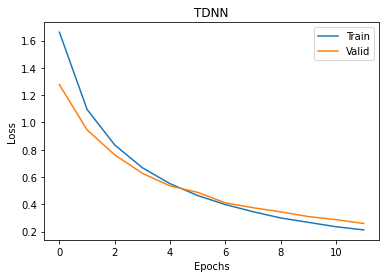

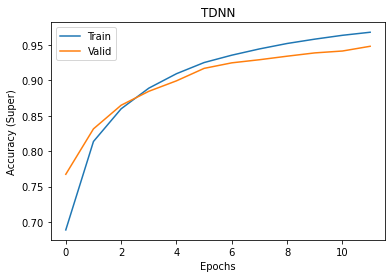

In [33]:
import matplotlib.pyplot as plt


model_name = "TDNN"
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title(model_name)

res_path = os.path.join("./", "results", str(max_sample_length))
os.makedirs(res_path, exist_ok=True)
plt.savefig(os.path.join(res_path, "loss_plot" + str(max_sample_length)))

plt.show()

plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Valid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (Super)")
plt.legend()
plt.title(model_name)

res_path = os.path.join("./", "results", str(max_sample_length))
os.makedirs(res_path, exist_ok=True)
plt.savefig(os.path.join(res_path, "accuracy_plot" + str(max_sample_length)))

plt.show()

In [34]:
# English accuracy
count = 0
correct = 0
for x, y in val_set:
  if y != 0:
    continue

  count += 1
  # Send to GPU if available
  if device is not None:
    x = x.to(device)
    y = y.to(device)
  x = x.unsqueeze(0)

  y_pred = net(x)
  y_pred = torch.mean(y_pred, 1)
  y_pred = F.softmax(y_pred, dim=1)
    
#   print(y_pred.amax(1, keepdim=True).item())
    
  top_pred = y_pred.argmax(1, keepdim=True)

  if top_pred == y:
    correct += 1
        
print(count)
print(correct)
print(correct / count)

206
206
1.0


In [41]:
# Add out of set to test set

test = []
ll = langs[32:]

for i,lang in enumerate(["ENG"]):
    print(lang, "(In-set)" if lang in in_set else "(Out-of-set)")
    for f_idx in range(27, 31):
        filepath = root_dir + lang + '/data/raw_mfcc_pitch_' + lang + '.' + str(f_idx) + '.ark'

        chunks = []
        for key, numpy_array in kaldiio.load_ark(filepath):
            chunks +=  [numpy_array]

        random.shuffle(chunks)

        for j in range(len(chunks)):
            chunk = chunks[j]
            inputs = torch.from_numpy(np.expand_dims(chunk, axis=0))
            inputs.to(device)
            labels = torch.from_numpy(np.array([i if lang in in_set else -1]))
            labels.to(device)
            test.append((inputs,labels))
        
print(len(test))

ENG (In-set)
512


In [44]:
infile = open(LOAD_PATH + ".pickle", "rb")
new_net = Unpickler(infile).load()
infile.close()
# out_len = len(test)
# count = 0
# for x, y in val_set:
#     test.append((x.unsqueeze(0), y))
#     count += 1
#     if count == out_len:
#         break
    
print(len(test))
random.shuffle(test)

for thresh in [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    correct = 0
    for x, y in test:
      # Send to GPU if available
      if device is not None:
        x = x.to(device)
        y = y.to(device)

      y_pred = net(x)
      y_pred = torch.mean(y_pred, 1)
#       top_pred = y_pred.argmax(1, keepdim=True)
      y_pred = F.softmax(y_pred, dim=1)
#       print(y_pred)
    
      conf = y_pred.amax(1, keepdim=True).item()
      if conf > thresh:
          top_pred = y_pred.argmax(1, keepdim=True)
      else:
          top_pred = -1

      if top_pred == y:
        correct += 1
        
    print(thresh, correct / len(test))
    


TypeError: file must have 'read' and 'readline' attributes